# Display particles

In [12]:
import pandas as pd
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
import itertools 

from sklearn.cluster import DBSCAN

import sys
sys.path.append('/Users/glucia/Projects/DeepLearning/TrackingML')
from utils.terminal_colors import TerminalColors as tc
from core.geometry import DetectorGeometry

In [28]:
hits = pd.read_csv('../../data/train_1/event000001001-hits.csv')
particles = pd.read_csv('../../data/train_1/event000001001-particles.csv')
mc_truth = pd.read_csv('../../data/train_1/event000001001-truth.csv')

total_df = pd.merge(hits, mc_truth, on='hit_id', how='inner')

# add radial position and phi angle
total_df['r'] = np.sqrt(total_df['x'].values**2 + total_df['y'].values**2)
total_df['phi'] = np.arctan2(total_df['y'].values, total_df['x'].values)

print('Number of particles:', len(total_df['particle_id'].unique()))

Number of particles: 7700


### Vertexing

Using DBScan from scikit-learn for clustering

In [22]:
particle_df = total_df.query('particle_id != 0')
hit_positions = particle_df[['x', 'y', 'z']].values
clustering = DBSCAN(eps=0.01, min_samples=10).fit(hit_positions)
labels = clustering.labels_
unique_labels, counts = np.unique(labels, return_counts=True)
main_cluster_label = unique_labels[np.argmax(counts)]

main_cluster_hits = hit_positions[labels == main_cluster_label]
collistion_vertex = np.mean(main_cluster_hits, axis=0)

print('Collision vertex:', collistion_vertex)
print('Number of hits in the main cluster:', len(main_cluster_hits))

Collision vertex: [  1.69207667  -4.15470045 -43.89732811]
Number of hits in the main cluster: 76210


###  Compute solid angle that contains two hits and the vertex

Given two vectors $\vec{a}$, $\vec{b}$ that connect two points to a common vertex, the angle between them is given by
$$ \theta = arccos\left(\frac{\vec{a} \cdot \vec{b}}{|\vec{a}|\, |\vec{b}|}\right) $$

Let's consider the spherical surphace with radius equal to the higest magnitude of the two vectors.
Let's also consider the cone with its axis along the first vector and its side along the other vector, with length equal to the second vector.
The solid angle occupied by the cone in the sphere is given by the ratio between the area of the base of the cone ($\pi\,(|\vec{b}|\,sin\theta)^2$) and the square of the radius of the sphere ($|\vec{b}|$).

$$ \Omega \, \sim \, \frac{\pi\,(|\vec{b}|\,sin\theta)^2}{|\vec{b}|^2} = \pi\,sin^2\theta

In [44]:
def solid_angle(vertex, hit1, hit2):

    vertex = np.array(vertex)
    hit1 = np.array(hit1)
    hit2 = np.array(hit2)

    vertor1 = hit1 - vertex
    vertor2 = hit2 - vertex

    cos_theta = np.dot(vertor1, vertor2) / (np.linalg.norm(vertor1) * np.linalg.norm(vertor2))
    theta = np.arccos(cos_theta)

    return np.pi * np.sin(theta)**2

## Track length distribution

(array([   0.,  454.,  238.,  210.,  228.,  244.,  217.,  237.,  288.,
         375.,  735., 1127., 1214., 1004.,  639.,  319.,  125.,   32.,
          11.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 49 artists>)

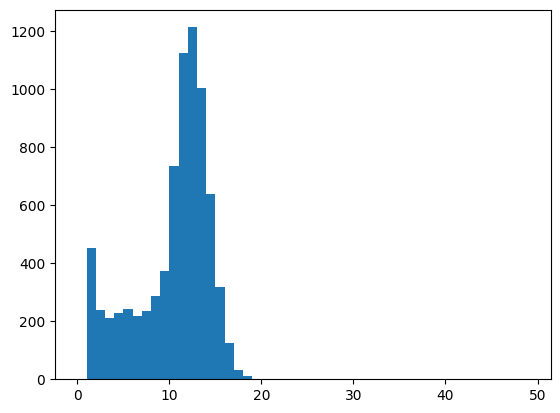

In [23]:
n_hits = total_df.groupby('particle_id')['hit_id'].count()

plt.hist(n_hits, bins=range(0, 50, 1))

## Track display

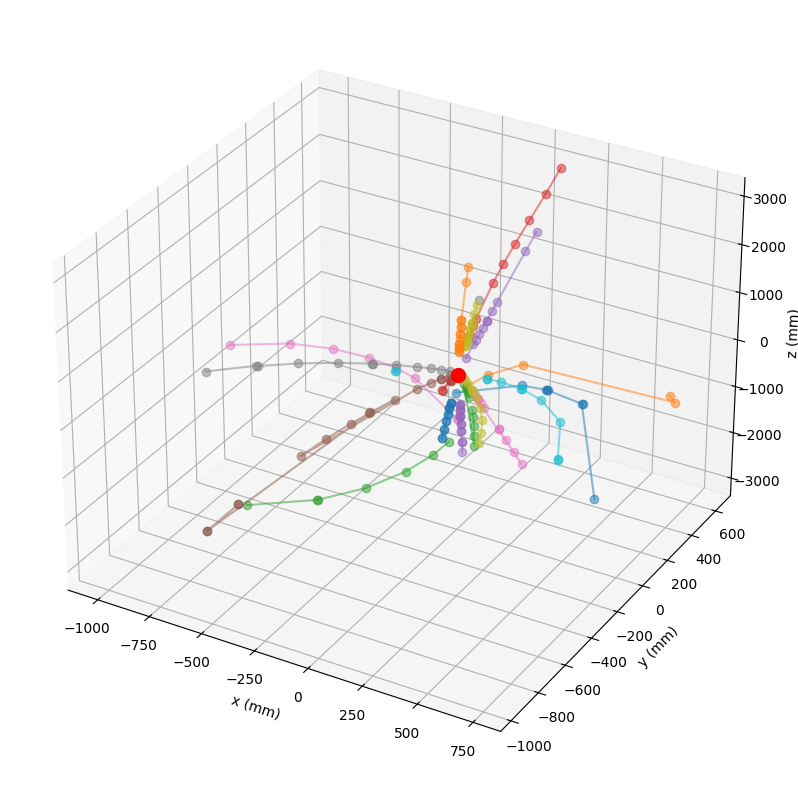

In [27]:
# reconstructed tracks

sub_df = total_df.query('particle_id != 0', inplace=False)

track_hits_dict = {}
for particle_id in sub_df['particle_id'].unique():
    track_hits_dict[particle_id] = [hit for hit in sub_df.query(f'particle_id == {particle_id}')['hit_id']]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

N_TRACKS = 20

tracks = {}
# select randomly N_TRACKS tracks
track_ids = np.random.choice(list(track_hits_dict.keys()), N_TRACKS)
for track_id in track_ids:
    track = sub_df.query(f'particle_id == {track_id}')[['x', 'y', 'z']]
    ax.plot(track['x'], track['y'], track['z'], label='particle_id: '+str(track_id), alpha=0.5, marker='o')

# plot collision vertex
ax.scatter(collistion_vertex[0], collistion_vertex[1], collistion_vertex[2], c='r', s=100, label='collision vertex')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()


Fraction of noise: 0.1864859094790777


(array([ 273.,   68.,   72.,   95.,  467.,   82.,   91.,  102.,  767.,
         117.,  131.,  123.,  133.,  138., 1023.,    0.,    0.,    0.,
           0.,    0.,    0.,   40.,  243.,  577.,   51.,   45.,   34.,
          33.,   38.,   42.,   41.,   37.,  272.,  872.,   41.,   48.,
          67.,   42.,   51.,   48.,   38.,   32.,   30.,   45.,   41.,
          35.,  339., 1246.,   36.,   44.,   49.,   68.,   36.,   54.,
          52.,   57.,   44.,   37.,   49.,   36.,   53.,   41.,  273.,
        1761.,   42.,   47.,   36.,   15.,    0.,    0.,    0.,    0.,
          41.,   27.,   30.,   23.,   36.,   36.,  257., 2160.,   40.,
          41.,   41.,   27.,   81.,   76.,   88.,   83.,   40.,   32.,
          50.,   37.,   40.,   29.,   35.,   44.,   36.,   40.,   83.,
        2977.]),
 array([  30.05962819,   40.01235986,   49.96509153,   59.9178232 ,
          69.87055487,   79.82328654,   89.77601821,   99.72874988,
         109.68148155,  119.63421322,  129.58694489,  139.53967656

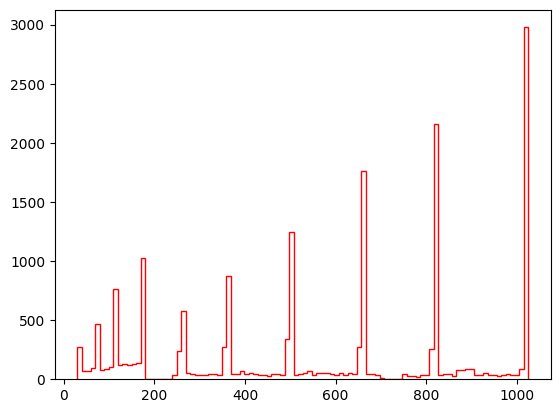

In [36]:
# Evaluate noise
noise = total_df.query('particle_id == 0')
print(tc.BOLD+'\nFraction of noise:'+tc.RESET, len(noise)/len(total_df))

# Noise radial density
plt.hist(noise['r'], bins=20)

### Solid angle distribution

Here is shown the solid angle distribution for tracks in the event.
The solid angle of the track is evaluated as the solid angle that contains the first and the last hit of the track.

Text(0, 0.5, 'Number of tracks')

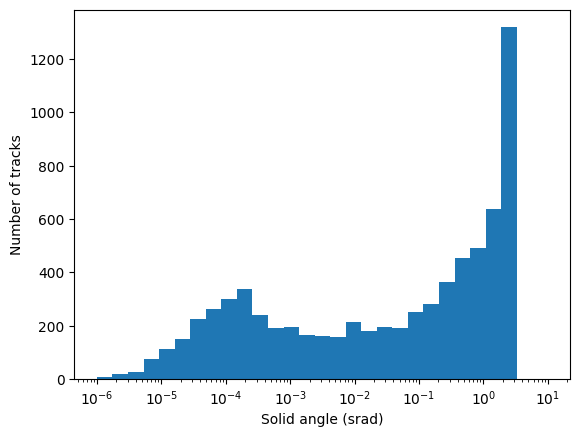

In [60]:
track_solid_angles = []
for track_id in track_hits_dict.keys():
    track = sub_df.query(f'particle_id == {track_id}')[['x', 'y', 'z']]
    track_hits = track[['x', 'y', 'z']].values
    if len(track_hits) > 1:
        track_solid_angles.append(solid_angle(collistion_vertex, track_hits[0], track_hits[-1]))

bins = np.logspace(-6, 1, 30)
plt.hist(track_solid_angles, bins=bins)
plt.xscale('log')
plt.xlabel('Solid angle (srad)')
plt.ylabel('Number of tracks')

Text(0, 0.5, 'Number of tracks')

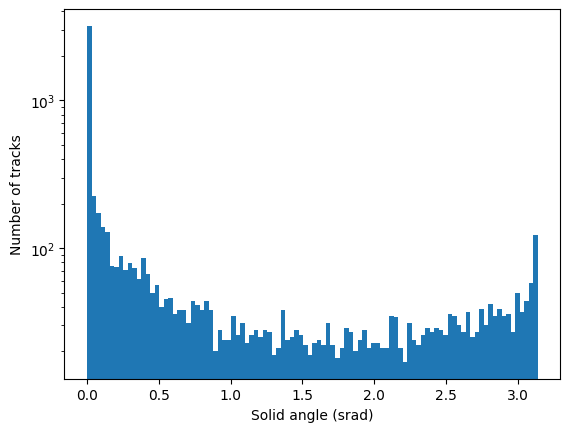

In [59]:
plt.hist(track_solid_angles, bins=100, log=True)

plt.xlabel('Solid angle (srad)')
plt.ylabel('Number of tracks')

(array([4259.,  467.,  312.,  260.,  191.,  157.,  146.,  140.,  137.,
          99.,  116.,  114.,  127.,  146.,  149.,  135.,  115.,   85.,
          56.,   34.]),
 array([3.49310030e-11, 1.57076144e-01, 3.14152288e-01, 4.71228432e-01,
        6.28304576e-01, 7.85380720e-01, 9.42456865e-01, 1.09953301e+00,
        1.25660915e+00, 1.41368530e+00, 1.57076144e+00, 1.72783758e+00,
        1.88491373e+00, 2.04198987e+00, 2.19906602e+00, 2.35614216e+00,
        2.51321831e+00, 2.67029445e+00, 2.82737059e+00, 2.98444674e+00,
        3.14152288e+00]),
 <BarContainer object of 20 artists>)

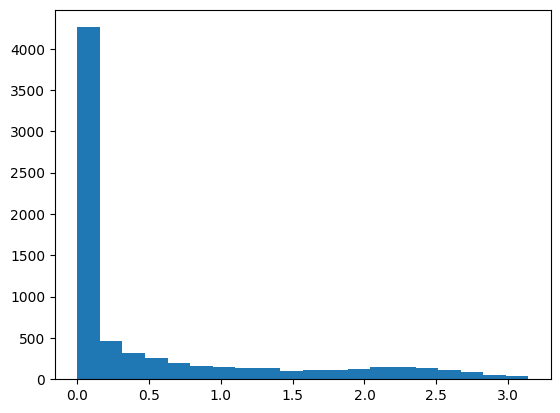

In [53]:
track_middle_solid_angles = []
for track_id in track_hits_dict.keys():
    track = sub_df.query(f'particle_id == {track_id}')[['x', 'y', 'z']]
    track_hits = track[['x', 'y', 'z']].values
    if len(track_hits) > 1:
        middle = len(track_hits)//2
        track_middle_solid_angles.append(solid_angle(collistion_vertex, track_hits[0], track_hits[middle]))

plt.hist(track_middle_solid_angles, bins=20)

### Single track visualization

In [9]:
def show_track(particle_id, particle_df):

    track = particle_df.query(f'particle_id == {particle_id}')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(track['x'], track['y'], track['z'], marker='o', label='particle_id: '+str(particle_id))
    
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')
    plt.legend()
    plt.show()

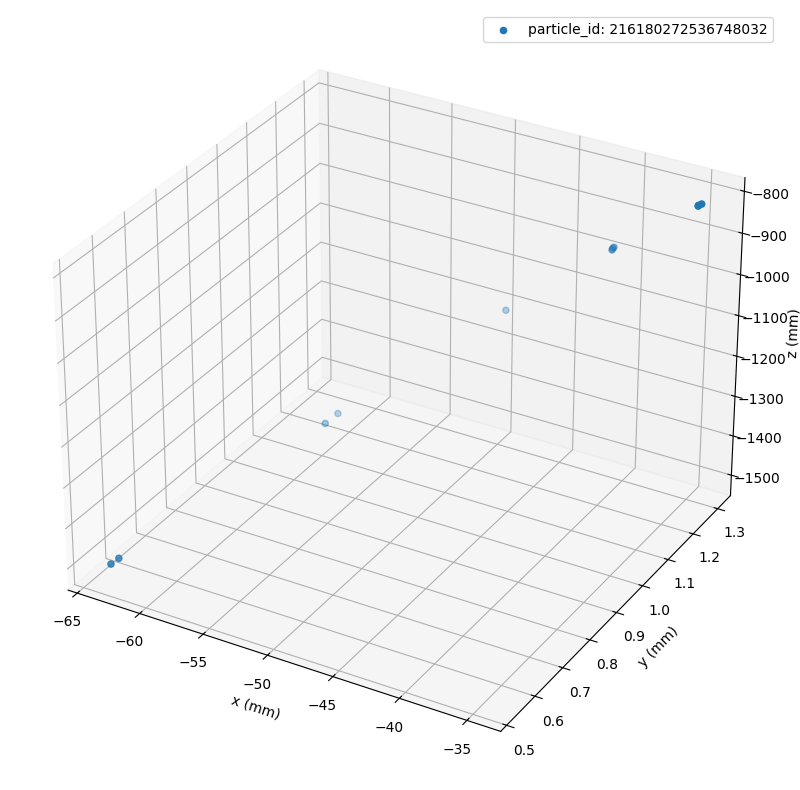

In [11]:
particle_ids = total_df['particle_id'].unique()

show_track(particle_ids[10], total_df)